# Aggregation frameworks in mongoDB

## What is the Aggregation Framework?

The Aggregation Framework is a powerful feature in MongoDB that allows for advanced data processing and analysis. It provides a way to perform complex queries and transformations on data within the database, similar to how we transform data using functions in pandas.

## Why Learn the Aggregation Framework?

There are several reasons why learning the Aggregation Framework in MongoDB is beneficial:

1. Data Transformation: The Aggregation Framework enables you to transform and manipulate data in MongoDB. It allows you to perform various operations, such as filtering, grouping, sorting, and projecting, to shape your data in the desired format.

2. Efficiency: The Aggregation Framework is designed to efficiently process large volumes of data within MongoDB. It takes advantage of indexes and native database operations, resulting in faster and more optimized queries compared to traditional querying methods.

3. Flexibility: The Aggregation Framework offers a flexible and extensible pipeline-based approach. You can chain multiple stages and operators together to create complex data processing pipelines tailored to your specific requirements. This flexibility allows you to handle a variety of data scenarios efficiently.

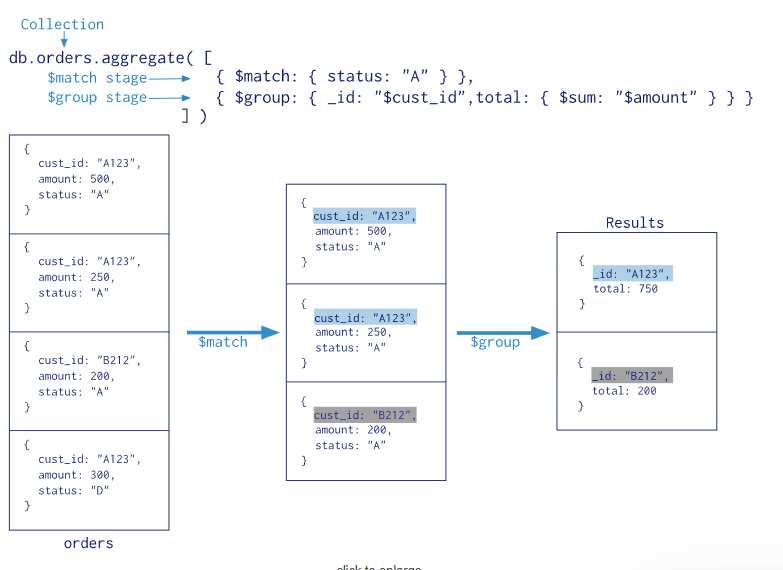
Figure: A visualization of how the collection evolves when passing through an aggregation pipeline.

## Pipeline 1 - Summarizing documents in a collection

Using `$match` and `$group` stages in a mongoDB aggregation pipeline
- `$$match: { <query> }`: specify criteria to filter ther documents that will be processed further in the pipeline.
- `$group: { _id: <expression>, // Group key <field1>: { <accumulator1> : <expression1> }, ...}`: perform grouping based on specified fields, and applies various accumulators to calculate aggregate values within each group.

Here is a pseudocode of this aggragation pipeline: 

In [ ]:
db.collection.aggregate([
  { $match: { condition: "some value" } },
  { $group: { _id: "$groupField", total: { $sum: "$valueField" } } }
]);

Here is an example of this aggregation pipeline:

In [ ]:
# initial documents in a collection:

db.sales.insertMany([
  { "_id" : 1, "item" : "abc", "price" : Decimal128("10"), "quantity" : Int32("2"), "date" : ISODate("2014-03-01T08:00:00Z") },
  { "_id" : 2, "item" : "jkl", "price" : Decimal128("20"), "quantity" : Int32("1"), "date" : ISODate("2014-03-01T09:00:00Z") },
  { "_id" : 3, "item" : "xyz", "price" : Decimal128("5"), "quantity" : Int32( "10"), "date" : ISODate("2014-03-15T09:00:00Z") },
  { "_id" : 4, "item" : "xyz", "price" : Decimal128("5"), "quantity" :  Int32("20") , "date" : ISODate("2014-04-04T11:21:39.736Z") },
  { "_id" : 5, "item" : "abc", "price" : Decimal128("10"), "quantity" : Int32("10") , "date" : ISODate("2014-04-04T21:23:13.331Z") },
  { "_id" : 6, "item" : "def", "price" : Decimal128("7.5"), "quantity": Int32("5" ) , "date" : ISODate("2015-06-04T05:08:13Z") },
  { "_id" : 7, "item" : "def", "price" : Decimal128("7.5"), "quantity": Int32("10") , "date" : ISODate("2015-09-10T08:43:00Z") },
  { "_id" : 8, "item" : "abc", "price" : Decimal128("10"), "quantity" : Int32("5" ) , "date" : ISODate("2016-02-06T20:20:13Z") },
])

# aggregation pipleine: that calculate cash value of sales (price times quantity) in a collection
db.sales.aggregate(
  [
    # First Stage
    # `$group`: groups the documents by `item` to retrieve the distinct item values, and return the `totalSaleAmount` for each items.
    {
      $group :
        {
          _id : "$item",
          totalSaleAmount: { $sum: { $multiply: [ "$price", "$quantity" ] } }
        }
     },
     # Second Stage
     # `$match`: filters the resulting documents to only return items with a `totalSaleAmount` greater than or equal to 100.
     {
       $match: { "totalSaleAmount": { $gte: 100 } }
     }
   ]
 )

# Expected result are as follows:
""" 
{ "_id" : "abc", "totalSaleAmount" : Decimal128("170") }
{ "_id" : "xyz", "totalSaleAmount" : Decimal128("150") }
{ "_id" : "def", "totalSaleAmount" : Decimal128("112.5") }
"""

## Pipeline 2: Retrieving a sorted subset of document

Using `$sort` and `$limit` stages in a mongoDB aggregation pipeline
- `$sort: { <field1>: <sort order>, <field2>: <sort order> ... }`: sort the documents based on one or more fields. If `<sort order>` is 1, it is in descending order; -1 then it is in ascending order. 
- `$limit: <positive 64-bit integer>`:  restrict the number of documents in the output

Here is an example aggregation pipeline of `$sort` + `$limit`:

In [ ]:
db.collection.aggregate([
  { $sort: { field1: 1 } },     # Sort documents in ascending order of field1
  { $limit: 10 }                # Retrieve only the first 10 documents
])

Here is a detailed example of `$sort` pipeline:

In [ ]:
db.restaurants.insertMany( [
   { "_id" : 1, "name" : "Central Park Cafe", "borough" : "Manhattan"},
   { "_id" : 2, "name" : "Rock A Feller Bar and Grill", "borough" : "Queens"},
   { "_id" : 3, "name" : "Empire State Pub", "borough" : "Brooklyn"},
   { "_id" : 4, "name" : "Stan's Pizzaria", "borough" : "Manhattan"},
   { "_id" : 5, "name" : "Jane's Deli", "borough" : "Brooklyn"},
] )

db.restaurants.aggregate(
   [
     { $sort : { borough : 1 } }
   ]
)

""" 
{ "_id" : 3, "name" : "Empire State Pub", "borough" : "Brooklyn" }
{ "_id" : 5, "name" : "Jane's Deli", "borough" : "Brooklyn" }
{ "_id" : 1, "name" : "Central Park Cafe", "borough" : "Manhattan" }
{ "_id" : 4, "name" : "Stan's Pizzaria", "borough" : "Manhattan" }
{ "_id" : 2, "name" : "Rock A Feller Bar and Grill", "borough" : "Queens" }
{ "_id" : 5, "name" : "Jane's Deli", "borough" : "Brooklyn" }
{ "_id" : 3, "name" : "Empire State Pub", "borough" : "Brooklyn" }
{ "_id" : 4, "name" : "Stan's Pizzaria", "borough" : "Manhattan" }
{ "_id" : 1, "name" : "Central Park Cafe", "borough" : "Manhattan" }
{ "_id" : 2, "name" : "Rock A Feller Bar and Grill", "borough" : "Queens" }

"""

## Pipeline 3: Get insights into the size and quantity of matched documents

Using `$project`, `$set` and `$count` stages in a mongoDB aggregation pipeline
- `$$project: { <specification(s)> }`: reshape documents in the pipeline by specifying which fields to include or exclude and by creating new computed fields
- `$count: <string>`: count the number of documents in the pipeline at a specific point
- `$set: { <newField>: <expression>, ... }`: add new fields or overwrite existing fields with new values

Here is the pseudocode of this pipeline:

In [ ]:
db.collection.aggregate([
  { $project: { field1: 1, field2: 1 } },  // Include only 'field1' and 'field2'
  { $set: { newField: { $add: ['$field1', '$field2'] } } },  // Create a new field 'newField' by adding 'field1' and 'field2'
  { $count: 'documentCount' }  // Count the number of documents in the pipeline
])

## Pipeline 4: Store the results of the pipeline into a specified collection

Using `$out` stage in a mongoDB aggregation pipeline

- `$out: { db: "<output-db>", coll: "<output-collection>" }`: store the aggregation results in a collection. It creates a new collection if it doesn't exist or replaces the existing collection if it does.

Here is an example of this pipeline:

In [ ]:
# in the `test` database, create a collection `book` with 5 documents: 
db.getSiblingDB("test").books.insertMany([
   { "_id" : 8751, "title" : "The Banquet", "author" : "Dante", "copies" : 2 },
   { "_id" : 8752, "title" : "Divine Comedy", "author" : "Dante", "copies" : 1 },
   { "_id" : 8645, "title" : "Eclogues", "author" : "Dante", "copies" : 2 },
   { "_id" : 7000, "title" : "The Odyssey", "author" : "Homer", "copies" : 10 },
   { "_id" : 7020, "title" : "Iliad", "author" : "Homer", "copies" : 10 }
])

# output perform grouping based on specified fields, 
# and applies various accumulators to calculate aggregate values within each group.
db.getSiblingDB("test").books.aggregate( [
    { $group : { _id : "$author", books: { $push: "$title" } } },
    { $out : "authors" }
] )

# Group stage: There are in total 2 authors, and the output collection `authors` has 2 groups:
""" 
{ "_id" : "Dante", "books" : [ "The Banquet", "Divine Comedy", "Eclogues" ] }
{ "_id" : "Homer", "books" : [ "The Odyssey", "Iliad" ] }
"""

# Next, we can query the `authors` collection to get the result:
""" 
db.getSiblingDB("test").authors.find()

{ "_id" : "Homer", "books" : [ "The Odyssey", "Iliad" ] }
{ "_id" : "Dante", "books" : [ "The Banquet", "Divine Comedy", "Eclogues" ] }
"""